# 화질 개선 - 손상된 의류 이미지 화질 복구하기

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

In [3]:
SEED = 34

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels),(test_images,test_labels) = fashion_mnist.load_data()

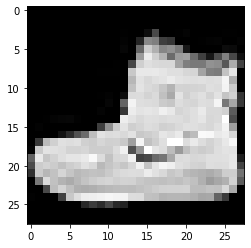

In [5]:
# 28,28 형태의 이미지 출력해보기

plt.imshow(train_images[0],cmap = 'gray')
plt.show()

In [6]:
print(train_images[train_images != 0][:10])

[  1  13  73   1   4   1   1   3  36 136]


In [7]:
train_images[:10].dtype

dtype('uint8')

In [8]:
# 전처리
print(train_images.shape, train_images.dtype)
print(train_images[train_images != 0][:10])
print('------------------------------------')
print(test_images.shape, test_images.dtype)
print(test_images[test_images != 0][:10])

(60000, 28, 28) uint8
[  1  13  73   1   4   1   1   3  36 136]
------------------------------------
(10000, 28, 28) uint8
[  3   1   7  37   1   2  27  84  11 119]


In [9]:
print(train_images.min(), train_images.max())

0 255


In [10]:
# 실수형으로 변경

In [11]:
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)

In [12]:
train_images.dtype, test_images.dtype

(dtype('float64'), dtype('float64'))

In [13]:
# 데이터 노멀라이즈 수행
# 최소값이 0이기때문에 아래와 같이 진행해도 됨.
train_images = train_images / 255
test_images = test_images/ 255

In [14]:
print(train_images.min(), train_images.max())
print(train_images.shape, train_images.dtype)

0.0 1.0
(60000, 28, 28) float64


In [15]:
# 흑백 이미지를 칼라 이미지로 변경하기

from skimage import color
train_images = color.gray2rgb(train_images)
train_images.shape   # (60000,28,28) -> (60000,28,28,3)
test_images = color.gray2rgb(test_images)
test_images.shape

(10000, 28, 28, 3)

In [16]:
# 시각화 해보기
five = train_images[:5]
five.shape

(5, 28, 28, 3)

In [18]:
# transpose 함수를 사용해서 shape 변경해보기
five.transpose((1,0,2,3)).reshape((28,-1,3)).shape

(28, 140, 3)

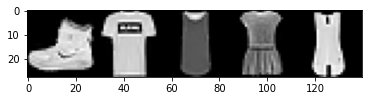

In [19]:
plt.imshow(five.transpose((1,0,2,3)).reshape((28,-1,3)))
plt.show()

In [20]:
# 노이즈 추가해보기
print( [np.random.random() for _ in range(3)] )


[0.13600006349616556, 0.5361253556742441, 0.517537540153691]


In [21]:
np.random.random((28,28,3)).shape

(28, 28, 3)

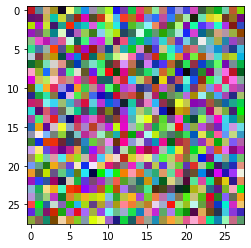

In [22]:
plt.imshow(np.random.random((28,28,3)))
plt.show()

In [23]:
# 가우시안 노이즈 함수 사용 (평균, 표준편차, 사이즈))
for _ in range(3):
    print(np.random.normal((0,0.1,1)))

[ 0.09302212 -0.00523835  0.54799641]
[ 0.27647472  1.21628702 -0.13934136]
[-0.44657108  1.34764489  1.97158951]


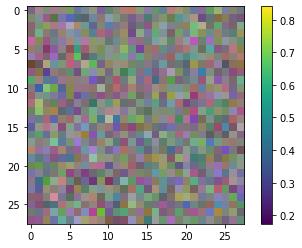

In [29]:
noisy = np.random.normal(0.5,0.1,(28,28,3))
noisy[noisy>1.0] = 1.0
plt.imshow(noisy)
plt.colorbar()
plt.show()

In [30]:
noisy_image = train_images[5]+noisy
noisy_image[noisy_image>1] = 1.0

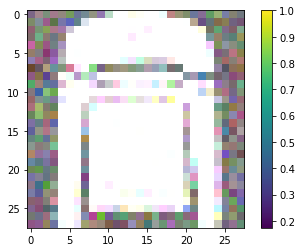

In [31]:
plt.imshow(noisy_image)
plt.colorbar()
plt.show()

In [32]:
train_images.shape

(60000, 28, 28, 3)

# 이미지에 노이즈 추가

In [33]:
train_noisy_images = train_images + np.random.normal(0.5,0.05,(train_images.shape))

In [35]:
train_noisy_images[train_noisy_images>1.0] = 1.0

In [36]:
test_noisy_images = test_images+np.random.normal(0.5, 0.05,test_images.shape)

In [38]:
test_noisy_images[test_noisy_images > 1.0] = 1.0

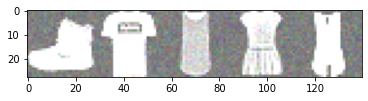

In [39]:
plt.imshow(train_noisy_images[:5].transpose((1,0,2,3)).reshape((28,-1,3)))
plt.show()

# 모델링

In [43]:
from tensorflow.keras.layers import Dense, Input,Conv2D, Conv2DTranspose,Flatten, Reshape
from tensorflow.keras.models import Model

def model():
    inputs = Input((28,28,3))
    x = Conv2D(32,3,2,activation = 'relu', padding = 'same')(inputs)
    x = Conv2D(64,3,2,activation = 'relu', padding = 'same')(x)
    x = Flatten()(x)
    latent = Dense(10)(x)
    
    x = Dense(7*7*64)(latent)
    x = Reshape((7,7,64))(x)
    x = Conv2DTranspose(64,3,2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(32,3,2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(3,3, activation='sigmoid', padding='same')(x)
    model = Model(inputs, x)
    return model

In [44]:
# 모델의 요약정보 출력
model = model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                31370     
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              34496     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0     

2021-12-29 17:42:30.430661: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-29 17:42:30.432521: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [45]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['acc'])

In [ ]:
# 테스트
plt.imshow(train_images)

In [47]:
print(train_images.shape, train_noisy_images.shape)
print(test_images.shape, test_noisy_images.shape)

(60000, 28, 28, 3) (60000, 28, 28, 3)
(10000, 28, 28, 3) (10000, 28, 28, 3)


In [48]:
hist = model.fit(train_noisy_images,
                train_images,
                validation_data=(test_noisy_images, test_images),
                epochs = 5,
                verbose = 1
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 479s 8ms/sample - loss: 0.0294 - acc: 0.3553 - val_loss: 0.0195 - val_acc: 0.4109
Epoch 2/5
60000/60000 [==============================] - 745s 12ms/sample - loss: 0.0184 - acc: 0.4562 - val_loss: 0.0174 - val_acc: 0.4773
Epoch 3/5
60000/60000 [==============================] - 1667s 28ms/sample - loss: 0.0168 - acc: 0.4818 - val_loss: 0.0161 - val_acc: 0.4846
Epoch 4/5
60000/60000 [==============================] - 691s 12ms/sample - loss: 0.0159 - acc: 0.4751 - val_loss: 0.0158 - val_acc: 0.4614
Epoch 5/5
60000/60000 [==============================] - 7740s 129ms/sample - loss: 0.0154 - acc: 0.4553 - val_loss: 0.0152 - val_acc: 0.4632


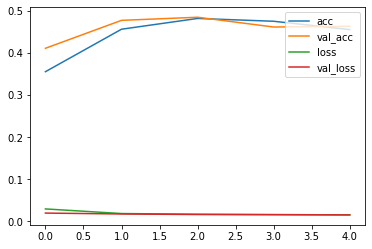

In [51]:
plt.plot(hist.history['acc'],label = 'acc')
plt.plot(hist.history['val_acc'], label = 'val_acc')
plt.plot(hist.history['loss'],label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

In [66]:
print(test_noisy_images[0:2].shape)
print(test_noisy_images[0].shape)

(2, 28, 28, 3)
(28, 28, 3)


In [53]:
res = model.predict(test_noisy_images[0:1])

In [76]:
res


array([[[[4.2283535e-04, 4.1714311e-04, 4.6068430e-04],
         [4.0531158e-06, 3.7848949e-06, 4.1425228e-06],
         [1.6093254e-06, 1.5199184e-06, 1.6987324e-06],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [1.4901161e-07, 1.4901161e-07, 8.9406967e-08],
         [8.9287758e-05, 6.6667795e-05, 7.5191259e-05]],

        [[2.3573637e-05, 2.2977591e-05, 2.3931265e-05],
         [0.0000000e+00, 8.9406967e-08, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [2.0861626e-07, 2.0861626e-07, 2.3841858e-07],
         [1.2871623e-04, 1.4537573e-04, 1.3336539e-04]],

        [[9.9539757e-06, 7.5697899e-06, 1.0728836e-05],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [3.5166740e-06, 3.1292439e-06, 3.6656857e-06],
  

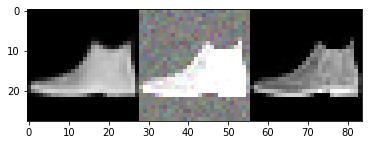

In [77]:
# res와 test_noisy_images[0], test_images[0]를 width 방향으로 결합하여 (28, 28 * 3, 3) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([res[0], test_noisy_images[0], test_images[0]], axis=1))
plt.show()

In [78]:
five = model.predict(test_noisy_images[0:5])

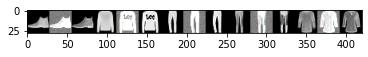

In [80]:
# 5장의 이미지를 모델에 넣고 결과를 31번과 같은 방식으로 비교하는 코드를 작성하세요
five = model.predict(test_noisy_images[0:5])
imgs = np.concatenate([five, test_noisy_images[0:5], test_images[0:5]], axis=2).transpose((1,0,2,3)).reshape((28, -1, 3))
plt.imshow(imgs)
plt.show()

In [81]:
model.save('./image_.h5')   # 모델을 저장